# ITAM: 
## Maestría en Ciencia de Datos, 
### Métodos analíticos para texto | Tarea 06 | 05 de mayo 2016 |
### Alumna: Gabriela Flores Bracamontes |  Clave: 160124 |

##  Clasificación  y agrupamiento de textos 

### Pre requisitos
* conda install -c anaconda gensim=0.12.4
* conda install seaborn

In [1]:
import codecs
import json, string, math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb  
import operator

import numpy as np
from numpy.linalg import *
import re
from collections import Counter
from __future__ import division
from nltk.stem.snowball import SnowballStemmer #import snowballstemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
from random import randint
import datetime

import getopt, sys, random, time, pprint
import collections
import gensim  as gns 

from scipy.stats.stats import pearsonr
from scipy import linalg as la, mat, dot
from sklearn.cluster import spectral_clustering
from sklearn.metrics.pairwise import cosine_similarity, laplacian_kernel
from sklearn.decomposition import TruncatedSVD 
from gensim.models import word2vec

from scipy import cluster
from matplotlib import pyplot
from scipy.spatial import distance

In [2]:
def remove_punctuation (text):
    text= text.replace('\r\n','').replace('!','').replace('¡','').replace('”','').replace('“','')
    return text.translate(str.maketrans("", "", punctuation))

def fix_encoding(s):
    return s.decode('utf8', 'ignore')

def text_to_words(text):
    words_only = re.sub("[^a-zA-Z]"," ",text.split())
    return words_only

def words_to_word(words):
    dictionary={}
    words = words.split()
    for i in range(len(words)):
        #if words[i] not in stopwords.words('spanish'):
        if not dictionary.has_key(words[i]):
            dictionary[words[i]]=words[i]
    return dictionary

def create_matrix(m,n,aleatory):
    maxdim = 0
    if (m>n) or (m==n) :
        maxdim = m
    else:
        maxdim = n
    if aleatory==True:
        matrix =[[randint(-maxdim, maxdim) for i in range(m)] for i in range(n)]
    else:
        matrix =[[0. for i in range(m)] for i in range(n)]
    return matrix

def euclidean_function(matrixSxW):
    A = np.array(create_matrix(len(matrixSxW),len(matrixSxW),False))
    for y in range(1,len(matrixSxW)):
        for x in range(1,len(matrixSxW)):
            if x!=y:
                A[y][x] = distance.euclidean(matrixSxW[y-1], matrixSxW[0])
    return A

def frobeniusdistance_function(matrixSxW):
    A = np.array(create_matrix(len(matrixSxW),len(matrixSxW),False))
    for x in range(A.shape[0]):
        for y in range(A.shape[0]):
            A[x,y] =np.sqrt(np.trace(np.dot(np.array(matrixSxW[x] - matrixSxW[y]).T, (matrixSxW[x] - matrixSxW[y]))))
    return A

def hausdorff_function(matrixSxW):
    X_y=[]
    for Y in matrixSxW:
        for X in matrixSxW:
            X_y.append(np.min([la.norm(Y.T-c) for c in X.T]))
    daf=np.array(X_y).reshape((56,56))
    A =np.zeros((daf.shape[0],daf.shape[0]))
    for xindex in range(A.shape[0]):
        for yindex in range(A.shape[0]):
            A[xindex,yindex]= max(daf[xindex,yindex],daf[yindex,xindex])
    return A

def svd_cust(matriz,dimension):
    U,s,V=linalg.svd(matriz,full_matrices=True)
    FA=dot(U[:,:dimension],np.diag(s[:dimension]))
    VT=np.transpose(V[:,:dimension])
    newf=dot(FA,VT)
    return pd.DataFrame(dot(FA,VT)[:,:dimension])
   
def open_file(pathfile):
    with codecs.open(pathfile,'r', encoding="utf8") as f: # Abrimos el archivo
        #data = f.read()
        data = f.readlines()
        f.close()
    return data

def make_graphic(Matrix, dictionary):
    %matplotlib inline
    sb.plt.plot(Matrix[:,0], Matrix[:,1], 'o')  
    for word, x, y in zip(dictionary, Matrix[:,0], Matrix[:,1]):  
        sb.plt.annotate(word, (x, y), size=12)
    return sb.plt.show()


def elbow_method(Matrix):
    %matplotlib inline
    #plot variance for each value for 'k' between 1,10
    initial = [cluster.vq.kmeans(Matrix,i) for i in range(1,56)]
    x= [var for (cent,var) in initial]
    pyplot.plot(x)
    pyplot.show()
    return np.array(x)

## 1.- Obtención y limpieza del corpus

In [3]:
corpus =  open_file('Frases.txt')

In [4]:
phrases_clasif = [remove_punctuation(phrase.lower()).split('\t') for phrase in corpus]

In [5]:
classes_only= {}
phrases_only =[]

for phrases in phrases_clasif:
    phrases_only.append(phrases[0].split())
    if not phrases[1] in classes_only:
        classes_only[phrases[1]]=phrases[1]

## 2.- Representación Vectorial utilizando Word2Vec

In [6]:
size = 100
modelo =  gns.models.Word2Vec(phrases_only, size, window=4, min_count=1, workers=4)
modelo.init_sims(replace=True)
vocab = sorted(modelo.vocab.keys())

SentenceXword = np.array([[int(word in phrase)*modelo[word]  for word in vocab] for phrase in phrases_only])


## 3.-  Representación de las oraciones

In [7]:
Suma = np.array(create_matrix(size,len(SentenceXword), False))
Multiplicacion = np.array(create_matrix(size,len(SentenceXword), False))
Frobenius = np.array(create_matrix(size,len(SentenceXword), False))

for y in range(len(SentenceXword)):
    for x in range(len(SentenceXword[y])):
        Suma[y]+= np.array(SentenceXword[y][x])
        Multiplicacion[y]=1
        if vocab[x] in phrases_only[y]:
            Multiplicacion[y]*= np.array(SentenceXword[y][x])

## Distancias utilizadas
1. ** Frobenius **
    $ ||X - Y||_{F}=\sqrt{tr((X-Y)^t(X-Y))} $
2. ** Hausdorff **
    $ d_{H}(X,Y)= máx \big\{  máx_{j} \big\|x_{j} -y^*(x_{j}) \big\| , máx_{i} \big\|y_{i} -x^*(y_{i}) \big\| \big\} $
3. ** Distancia Euclideana - Suma de vectores **
4. ** Distancia Euclideana - Multiplicación de vectores **

In [8]:
MSuma = euclidean_function(Suma)
MMultiplitacion= euclidean_function(Multiplicacion)
Mfrobenius = frobeniusdistance_function(SentenceXword)
Mahausdorff = hausdorff_function(SentenceXword)

## Elbow Method y K-medias
* Es una método que nos ayuda a determinar el # de clusters

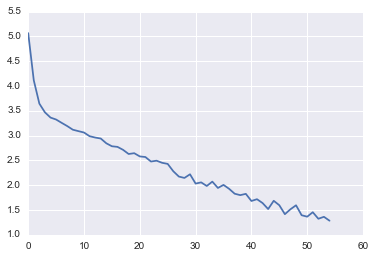

array([ 5.06602218,  4.11463045,  3.64450098,  3.46870439,  3.36331927,
        3.32402025,  3.25685407,  3.19167888,  3.11875597,  3.08990847,
        3.06207445,  2.98806952,  2.9605762 ,  2.94127499,  2.8449198 ,
        2.78512507,  2.7727241 ,  2.71297202,  2.62909975,  2.64524942,
        2.5803491 ,  2.56818955,  2.47722875,  2.49417641,  2.45150663,
        2.42940336,  2.28158384,  2.17416169,  2.14644725,  2.22022301,
        2.03262257,  2.05687   ,  1.98439588,  2.07191957,  1.9443616 ,
        2.00606919,  1.92755932,  1.82845896,  1.79965385,  1.82564329,
        1.68174829,  1.71776179,  1.64043349,  1.51933627,  1.68566081,
        1.59651122,  1.41583925,  1.51506103,  1.5950593 ,  1.39474602,
        1.36532009,  1.4553654 ,  1.32335184,  1.36265409,  1.28422062])

In [9]:
elbow_method(MSuma)

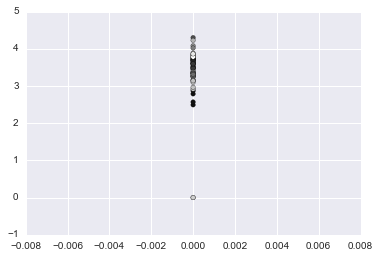

In [10]:
initial = [cluster.vq.kmeans(MSuma,i) for i in range(1,23)]
cent, var = initial[21]
#use vq() to get as assignment for each obs.
aSuma,cdist = cluster.vq.vq(MSuma,cent)
pyplot.scatter(MSuma[:,0], MSuma[:,1], c=aSuma)
pyplot.show()

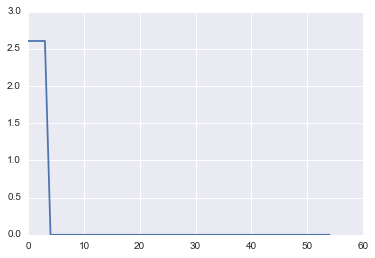

array([  2.60508270e+00,   2.60508270e+00,   2.60508270e+00,
         2.60508270e+00,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,   3.40597970e-08,   3.40597970e-08,
         3.40597970e-08,

In [11]:
elbow_method(MMultiplitacion)

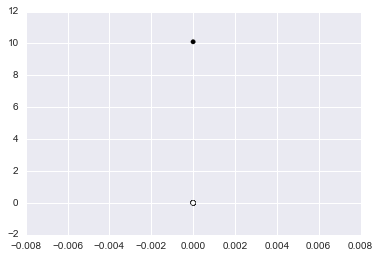

In [12]:
initial = [cluster.vq.kmeans(MMultiplitacion,i) for i in range(1,23)]
cent, var = initial[21]
#use vq() to get as assignment for each obs.
aMul,cdist = cluster.vq.vq(MMultiplitacion,cent)
pyplot.scatter(MMultiplitacion[:,0], MMultiplitacion[:,1], c=aMul)
pyplot.show()

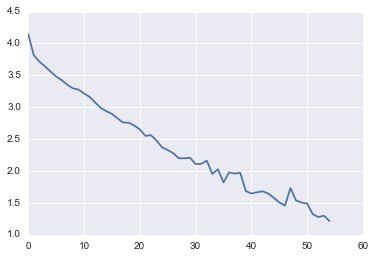

array([ 4.14684059,  3.81659587,  3.7166715 ,  3.64164983,  3.56064592,
        3.48200091,  3.42614697,  3.35338219,  3.29808683,  3.27756878,
        3.2170162 ,  3.16281416,  3.0750767 ,  2.99007431,  2.93877251,
        2.89525425,  2.82654609,  2.76094954,  2.75740859,  2.71419474,
        2.65243582,  2.55156792,  2.56229037,  2.47781918,  2.37030223,
        2.33022331,  2.27939122,  2.19965236,  2.1999486 ,  2.2074034 ,
        2.11003162,  2.11247523,  2.1623812 ,  1.95534462,  2.02806471,
        1.82134223,  1.97959555,  1.95912735,  1.97197522,  1.68592492,
        1.6484276 ,  1.66588989,  1.68198233,  1.64752531,  1.58072501,
        1.50767483,  1.45771494,  1.73302365,  1.5383878 ,  1.50519764,
        1.49017418,  1.32341348,  1.27869593,  1.29984667,  1.21510965])

In [13]:
elbow_method(Mfrobenius)

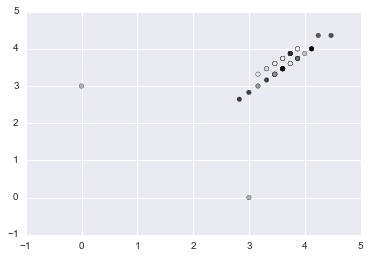

In [14]:
initial = [cluster.vq.kmeans(Mfrobenius,i) for i in range(1,23)]
cent, var = initial[21]
#use vq() to get as assignment for each obs.
afrob,cdist = cluster.vq.vq(Mfrobenius,cent)
pyplot.scatter(Mfrobenius[:,0], Mfrobenius[:,1], c=afrob)
pyplot.show()

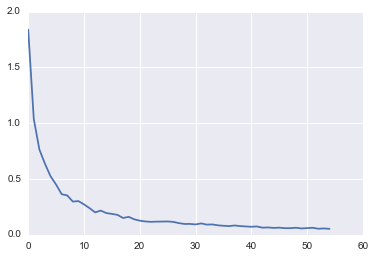

array([ 1.83810952,  1.03780384,  0.76487713,  0.63723352,  0.52484424,
        0.44986197,  0.36378993,  0.35271702,  0.29762628,  0.30206447,
        0.2724038 ,  0.2385443 ,  0.20083411,  0.21702191,  0.19471966,
        0.18741108,  0.17860569,  0.1504415 ,  0.1609772 ,  0.13883306,
        0.1263114 ,  0.1197065 ,  0.11594985,  0.11812792,  0.11852555,
        0.11987518,  0.11553255,  0.10484108,  0.09695276,  0.09755317,
        0.0929794 ,  0.10196432,  0.0913133 ,  0.0930063 ,  0.08502494,
        0.08101663,  0.07817742,  0.08353962,  0.07820299,  0.07476404,
        0.0721216 ,  0.07483754,  0.06376669,  0.06595753,  0.06181044,
        0.06410414,  0.05910426,  0.05959814,  0.06333663,  0.05690609,
        0.06009715,  0.06272945,  0.05426688,  0.05702696,  0.05361295])

In [15]:
elbow_method(Mahausdorff)

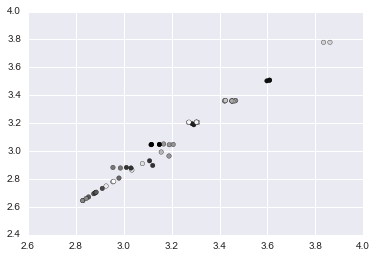

In [16]:
initial = [cluster.vq.kmeans(Mahausdorff,i) for i in range(1,23)]
cent, var = initial[21]
#use vq() to get as assignment for each obs.
ahaus,cdist = cluster.vq.vq(Mahausdorff,cent)
pyplot.scatter(Mahausdorff[:,0], Mahausdorff[:,1], c=ahaus)
pyplot.show()

## Accuracy

In [18]:
comparativa = pd.DataFrame ({'Original':[phrases_clasif[i][1] for i in range(len(phrases_clasif))] , \
                             'Multiplicación': [aMul[i] for i in aMul], \
                             'Frobeniuse': [afrob[i] for i in afrob], 'Haussdorf': [ahaus[i] for i in ahaus],\
                             'Suma': [aSuma[i] for i in aSuma] \
                            })


In [19]:
comparativa

,Frobeniuse,Haussdorf,Multiplicación,Original,Suma
0,10,1,0,agua,14
1,10,13,0,agua,14
2,17,6,0,comida,15
3,10,0,0,animales,2
4,8,0,0,dios,4
5,13,1,0,relaciones sociales,2
6,1,0,0,partes del cuerpo,6
7,1,13,0,objetos,9
8,17,16,0,animales,4
9,17,6,0,objetos,9


In [20]:
accuracy_suma=sum([aSuma[i] for i in aSuma])/len(classes_only)
accuracy_mult=sum([aMul[i] for i in aMul])/len(classes_only)
accuracy_fro=sum([afrob[i] for i in afrob])/len(classes_only)
accuracy_hau=sum([ahaus[i] for i in ahaus])/len(classes_only)

In [30]:
print ('||Suma:',accuracy_suma, '||Multiplitación: ',accuracy_mult, '||Frobenius', accuracy_fro, '|| Hausdorf: ',accuracy_hau)


||Suma: 21.1904761905 ||Multiplitación:  0.0 ||Frobenius 22.2857142857 || Hausdorf:  25.8571428571
